In [13]:
import pandas as pd
import json
from glob import glob
import os

def load_json_from_txt(file_path):
    """
    Load JSON content from a .txt file
    """
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON from {file_path}: {e}")
        return None
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

def extract_model_metrics(json_data):
    """
    Extract all metrics and fields from the JSON data structure into a flat dictionary
    """
    if not json_data:
        return None

    metrics = {
        # Model Info
        'model_name': json_data['model_info']['name'],
        'model_version': json_data['model_info']['version'],
        'provider': json_data['model_info']['provider'],
        'timestamp': json_data['model_info']['timestamp'],

        # Performance Metrics - Critical
        'critical_total_caught': json_data['performance_metrics']['detection_rate']['critical']['total_caught'],
        'critical_total_possible': json_data['performance_metrics']['detection_rate']['critical']['total_possible'],
        'critical_percentage': json_data['performance_metrics']['detection_rate']['critical']['percentage'],

        # Performance Metrics - Warning
        'warning_total_caught': json_data['performance_metrics']['detection_rate']['warning']['total_caught'],
        'warning_total_possible': json_data['performance_metrics']['detection_rate']['warning']['total_possible'],
        'warning_percentage': json_data['performance_metrics']['detection_rate']['warning']['percentage'],

        # Performance Metrics - Info
        'info_total_caught': json_data['performance_metrics']['detection_rate']['info']['total_caught'],
        'info_total_possible': json_data['performance_metrics']['detection_rate']['info']['total_possible'],
        'info_percentage': json_data['performance_metrics']['detection_rate']['info']['percentage'],

        # Performance Metrics - Overall
        'overall_total_caught': json_data['performance_metrics']['detection_rate']['overall']['total_caught'],
        'overall_total_possible': json_data['performance_metrics']['detection_rate']['overall']['total_possible'],
        'overall_percentage': json_data['performance_metrics']['detection_rate']['overall']['percentage'],

        # Additional Performance Metrics
        'false_positives': json_data['performance_metrics']['false_positives'],
        'missed_vulnerabilities': json_data['performance_metrics']['missed_vulnerabilities']
    }

    # Error Detection for each file
    files = ['UserService.ts', 'TransactionProcessor.ts', 'DatabaseConnection.ts',
             'OrderController.ts', 'CacheManager.ts', 'DataTransformer.ts',
             'LogProcessor.ts', 'RateLimiter.ts', 'DataProcessor.ts', 'ConfigLoader.ts']

    for filename in files:
        if filename in json_data['error_detection']:
            for error_id, error_data in json_data['error_detection'][filename].items():
                base_key = f"{filename.replace('.ts', '')}_{error_id}"
                metrics[f"{base_key}_description"] = error_data['description']
                metrics[f"{base_key}_severity"] = error_data['severity']
                metrics[f"{base_key}_detected"] = error_data['detected']

    for key, value in metrics.items():
        if isinstance(value, list):
            metrics[key] = '; '.join(value) if value else ''

    return metrics

def process_all_files(directory_path):
    """
    Process all .txt files in the specified directory and create a DataFrame
    """
    all_metrics = []

    # Find all .txt files in the directory
    txt_files = glob(os.path.join(directory_path, '*.txt'))

    for file_path in txt_files:
        json_data = load_json_from_txt(file_path)
        if json_data:
            metrics = extract_model_metrics(json_data)
            if metrics:
                all_metrics.append(metrics)

    # Create DataFrame
    df = pd.DataFrame(all_metrics)

    # Convert percentage columns to float
    percentage_columns = [col for col in df.columns if 'rate' in col]
    for col in percentage_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

In [19]:
directory_path = '/content/json'

df = process_all_files(directory_path)
df

,model_name,model_version,provider,timestamp,critical_total_caught,critical_total_possible,critical_percentage,warning_total_caught,warning_total_possible,warning_percentage,...,ConfigLoader_error_CL002_detected,ConfigLoader_error_CL003_description,ConfigLoader_error_CL003_severity,ConfigLoader_error_CL003_detected,ConfigLoader_error_CL004_description,ConfigLoader_error_CL004_severity,ConfigLoader_error_CL004_detected,ConfigLoader_error_CL005_description,ConfigLoader_error_CL005_severity,ConfigLoader_error_CL005_detected
0,GPT-4,4-0-2024-08-06,OpenAI,2024-11-19,8,10,80,19,24,79.2,...,False,No config validation,WARNING,True,No environment variables support,WARNING,True,Missing config reload capability,INFO,True
1,Gemini,1.5-flash-latest,Google,2024-11-19,5,10,50,6,24,25.0,...,False,No config validation,WARNING,False,No environment variables support,WARNING,False,Missing config reload capability,INFO,False
2,GPT-4,4-0-mini-2024-07-18,OpenAI,2024-11-19,10,10,100,12,24,50.0,...,False,No config validation,WARNING,True,No environment variables support,WARNING,False,Missing config reload capability,INFO,False
3,Claude,3-5-haiku,Anthropic,2024-11-19,9,10,90,18,24,75.0,...,True,No config validation,WARNING,True,No environment variables support,WARNING,True,Missing config reload capability,INFO,True
4,Claude,3-5-sonnet,Anthropic,2024-11-19,10,10,100,20,24,83.3,...,True,No config validation,WARNING,True,No environment variables support,WARNING,True,Missing config reload capability,INFO,False
5,Gemini,1.5-flash-8b,Google,2024-11-19,3,10,30,0,24,0.0,...,False,No config validation,WARNING,False,No environment variables support,WARNING,False,Missing config reload capability,INFO,False
6,GPT,3.5-turbo-0125,OpenAI,2024-11-19,4,10,40,3,24,12.5,...,False,No config validation,WARNING,False,No environment variables support,WARNING,False,Missing config reload capability,INFO,False


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

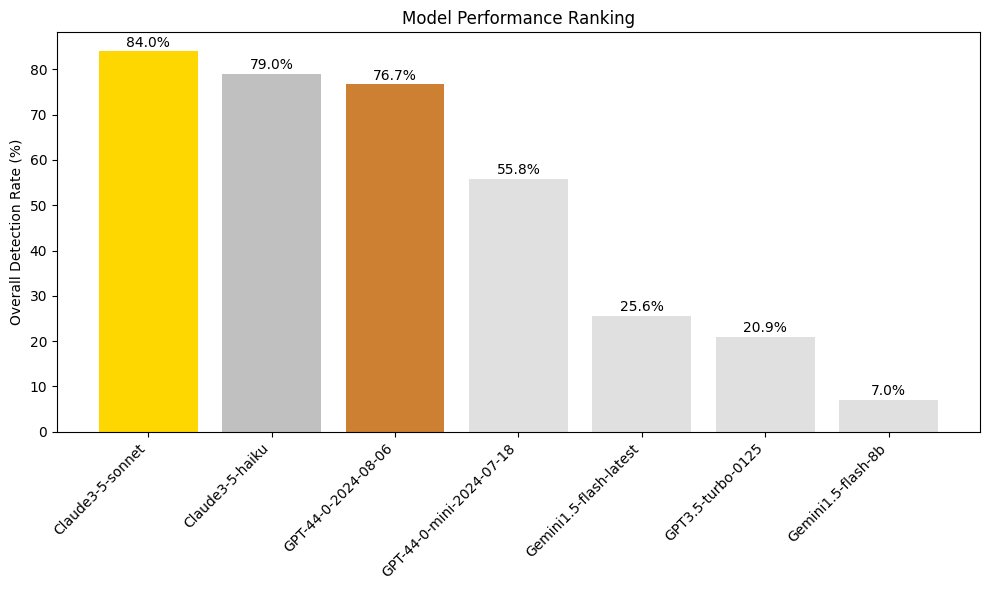

In [48]:
def plot_top_performers():
    """
    Simple bar chart showing overall performance ranking
    """
    plt.figure(figsize=(10, 6))

    # Sort models by overall performance
    performance_data = df.sort_values('overall_percentage', ascending=False)

    # Create bar plot with different colors for top 3
    # Using hex colors for gold, silver, and bronze
    colors = ['#FFD700',  # gold
             '#C0C0C0',   # silver
             '#CD7F32',   # bronze
             ] + ['#E0E0E0'] * (len(df) - 3)  # light gray for the rest

    plt.bar(range(len(performance_data)), performance_data['overall_percentage'], color=colors)

    # Add model names and percentages
    plt.xticks(range(len(performance_data)),
               performance_data['model_name']+performance_data['model_version'],
               rotation=45,
               ha='right')

    # Add percentage labels on top of bars
    for i, v in enumerate(performance_data['overall_percentage']):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center')

    plt.title('Model Performance Ranking')
    plt.ylabel('Overall Detection Rate (%)')
    plt.tight_layout()
    return plt

plot_top_performers()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

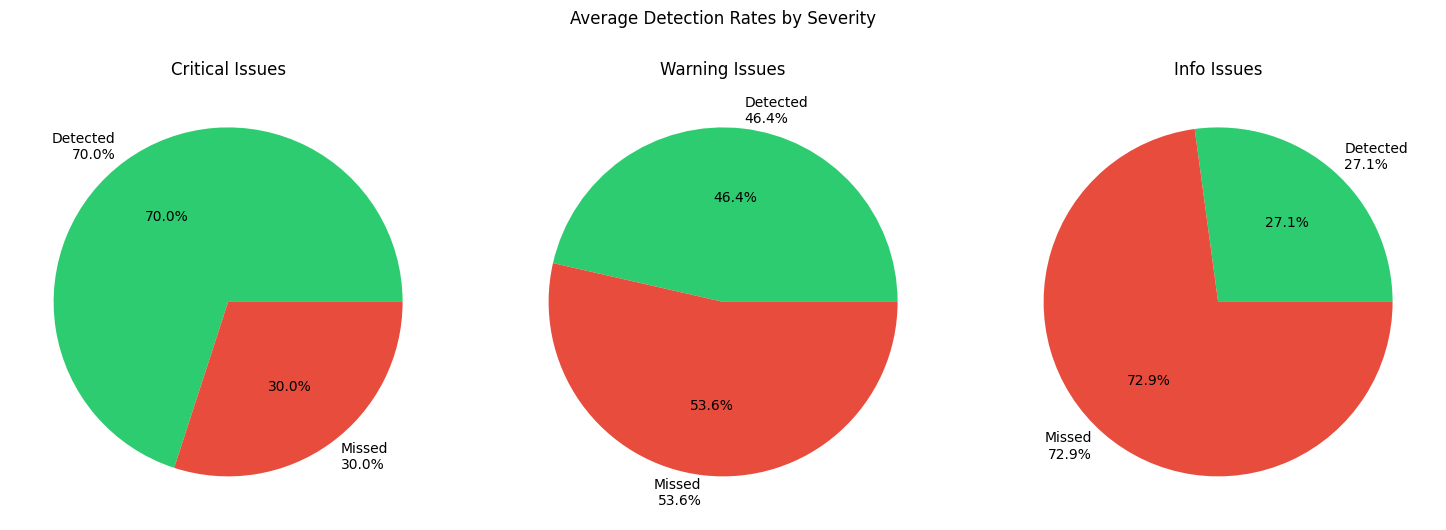

In [35]:
def plot_success_failure():
    """
    Simple pie charts showing success vs failure rates for each severity level
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Calculate average success rates
    critical_success = df['critical_percentage'].mean()
    warning_success = df['warning_percentage'].mean()
    info_success = df['info_percentage'].mean()

    # Create pie charts
    def make_pie(ax, success, title):
        ax.pie([success, 100-success],
               labels=[f'Detected\n{success:.1f}%', f'Missed\n{(100-success):.1f}%'],
               colors=['#2ecc71', '#e74c3c'],
               autopct='%1.1f%%')
        ax.set_title(title)

    make_pie(ax1, critical_success, 'Critical Issues')
    make_pie(ax2, warning_success, 'Warning Issues')
    make_pie(ax3, info_success, 'Info Issues')

    plt.suptitle('Average Detection Rates by Severity', y=1.05)
    plt.tight_layout()
    return plt

plot_success_failure()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

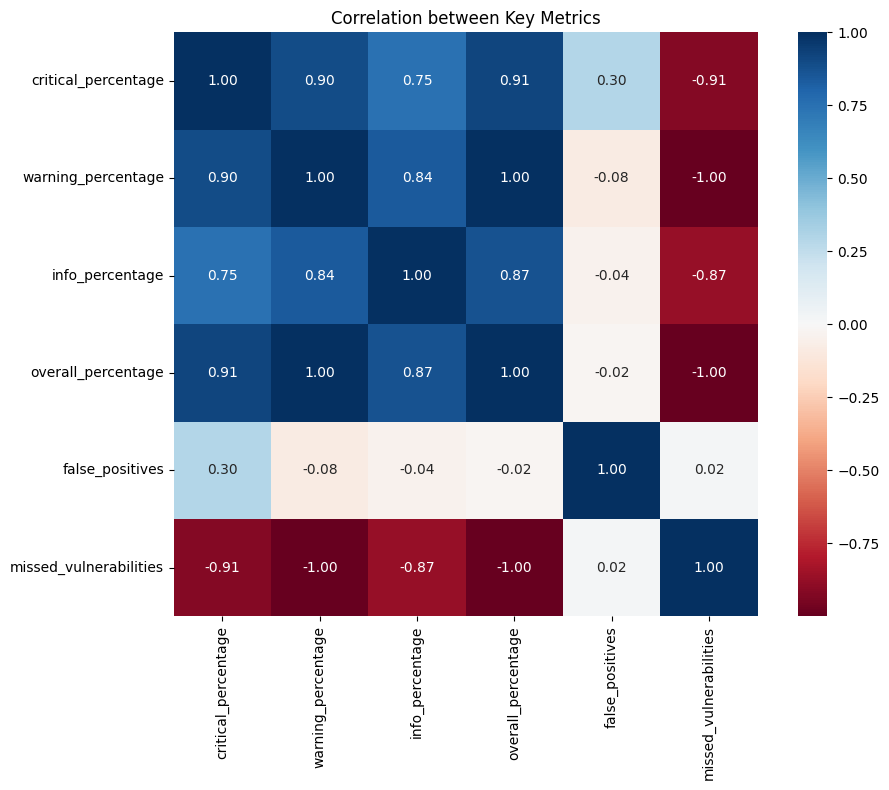

In [38]:
def plot_correlation_heatmap():
    """
    Simple correlation heatmap of key metrics
    """
    # Select relevant numeric columns
    metrics = ['critical_percentage', 'warning_percentage', 'info_percentage',
              'overall_percentage', 'false_positives', 'missed_vulnerabilities']

    # Calculate correlation matrix
    corr_matrix = df[metrics].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix,
                annot=True,
                cmap='RdBu',
                center=0,
                fmt='.2f',
                square=True)

    plt.title('Correlation between Key Metrics')
    plt.tight_layout()
    return plt

plot_correlation_heatmap()

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Detection Rates Comparison Radar Chart
def plot_detection_rates_radar(df):
    """
    Creates a radar chart comparing detection rates across different severity levels for each model.
    This helps identify which models perform better at different types of issues.
    """
    categories = ['critical_percentage', 'warning_percentage',
                 'info_percentage', 'overall_percentage']

    fig = go.Figure()
    for idx, row in df.iterrows():
        fig.add_trace(go.Scatterpolar(
            r=[row[cat] for cat in categories],
            theta=categories,
            name=f"{row['model_name']} {row['model_version']}"
        ))

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 100])),
        title="Detection Rates by Model and Severity",
        showlegend=True
    )
    return fig

plot_detection_rates_radar(df)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

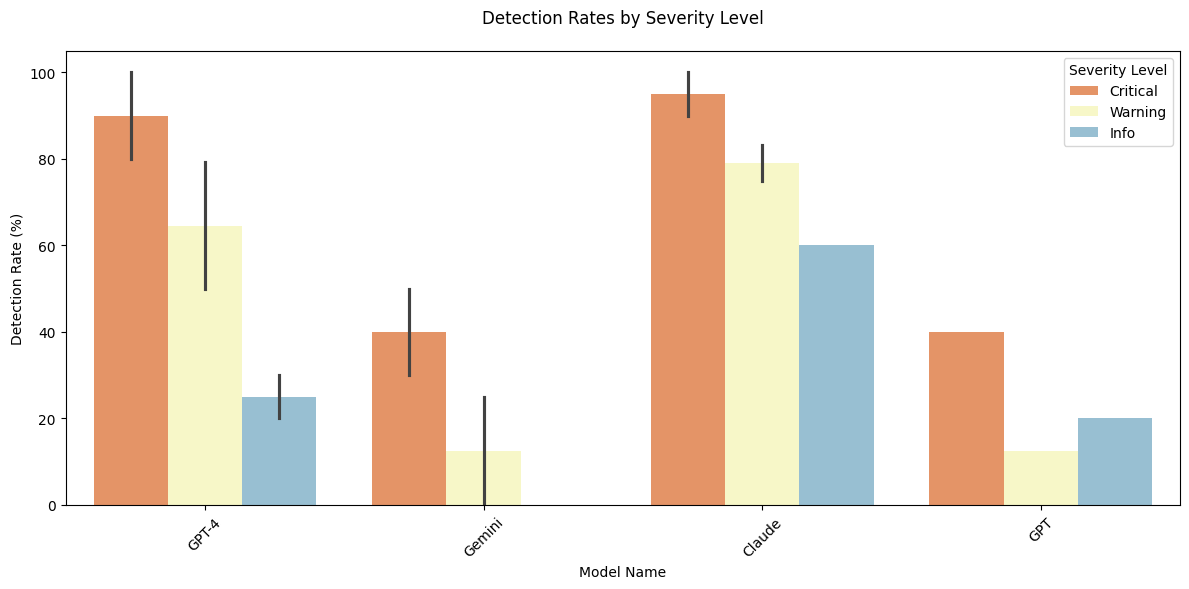

In [29]:
def plot_severity_breakdown():
    """
    Creates a grouped bar chart showing detection rates for each severity level
    """
    severity_metrics = ['critical_percentage', 'warning_percentage', 'info_percentage']
    plot_data = df.melt(id_vars=['model_name'],
                       value_vars=severity_metrics,
                       var_name='Severity',
                       value_name='Percentage')

    # Clean up severity labels
    plot_data['Severity'] = plot_data['Severity'].map({
        'critical_percentage': 'Critical',
        'warning_percentage': 'Warning',
        'info_percentage': 'Info'
    })

    plt.figure(figsize=(12, 6))
    sns.barplot(x='model_name', y='Percentage', hue='Severity',
                data=plot_data, palette='RdYlBu')

    plt.title('Detection Rates by Severity Level', pad=20)
    plt.xticks(rotation=45)
    plt.xlabel('Model Name')
    plt.ylabel('Detection Rate (%)')

    plt.legend(title='Severity Level')
    plt.tight_layout()
    return plt

plot_severity_breakdown()

In [31]:
def plot_error_comparison():
    """
    Creates a scatter plot comparing false positives and missed vulnerabilities
    """
    fig = px.scatter(df, x='false_positives', y='missed_vulnerabilities',
                    color='overall_percentage',
                    size='overall_total_caught',
                    hover_data=['model_name', 'provider'],
                    title='False Positives vs Missed Vulnerabilities',
                    labels={'false_positives': 'False Positives',
                           'missed_vulnerabilities': 'Missed Vulnerabilities',
                           'overall_percentage': 'Overall Detection Rate (%)'})

    fig.update_layout(
        height=600,
        width=800,
        showlegend=True
    )
    return fig

plot_error_comparison()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

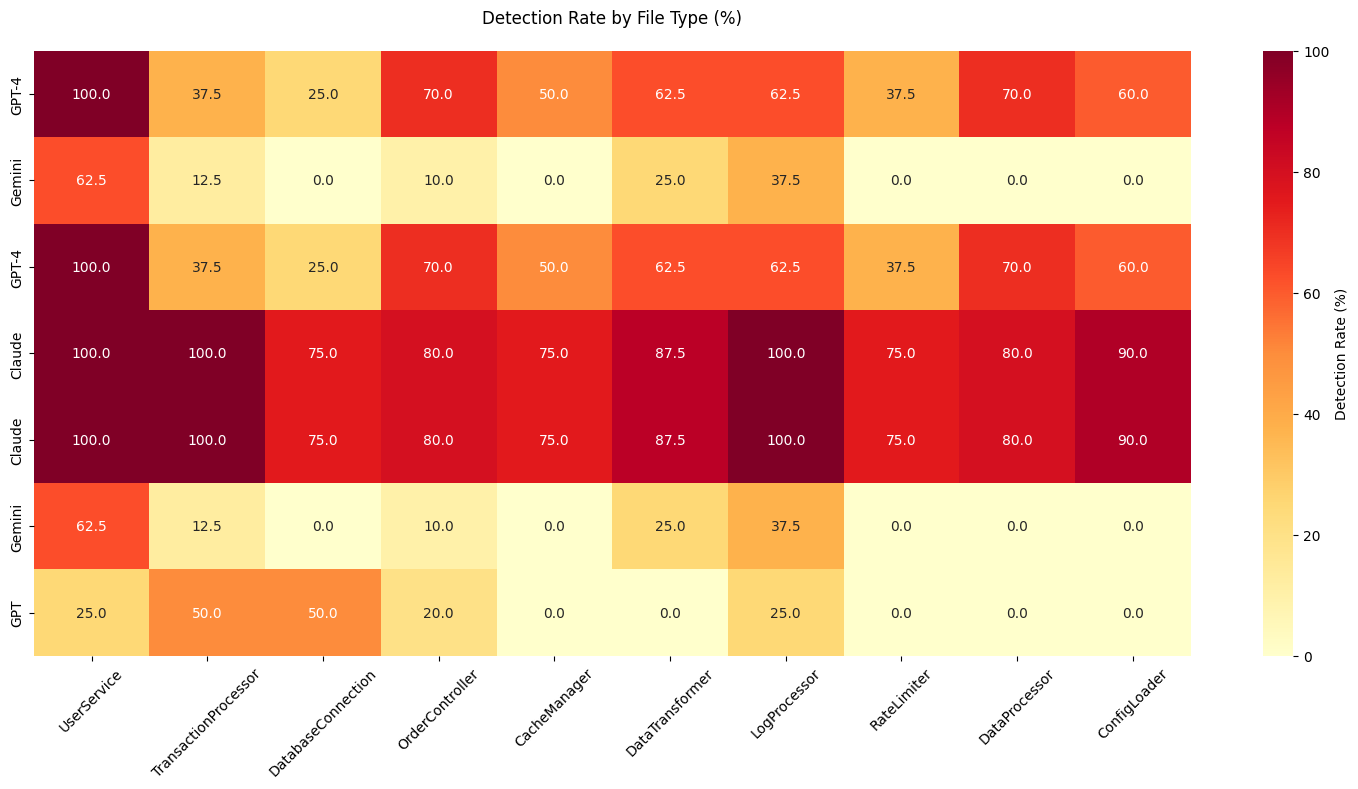

In [32]:
def plot_file_performance():
    """
    Creates a heatmap showing detection rates across different file types
    """
    # Extract detection rates per file type
    file_types = ['UserService', 'TransactionProcessor', 'DatabaseConnection',
                  'OrderController', 'CacheManager', 'DataTransformer',
                  'LogProcessor', 'RateLimiter', 'DataProcessor', 'ConfigLoader']

    detection_matrix = []
    for model in df['model_name']:
        model_data = []
        for file_type in file_types:
            # Calculate detection rate for this file type
            detected_cols = [col for col in df.columns if
                           file_type in col and col.endswith('_detected')]
            detection_rate = df[df['model_name'] == model][detected_cols].mean().mean() * 100
            model_data.append(detection_rate)
        detection_matrix.append(model_data)

    # Create heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(detection_matrix,
                xticklabels=file_types,
                yticklabels=df['model_name'],
                annot=True,
                fmt='.1f',
                cmap='YlOrRd',
                cbar_kws={'label': 'Detection Rate (%)'})

    plt.title('Detection Rate by File Type (%)', pad=20)
    plt.xticks(rotation=45)
    plt.tight_layout()
    return plt

plot_file_performance()

In [40]:
def plot_3d_performance():
    """
    Creates an interactive 3D bubble chart comparing critical, warning, and info detection rates
    """
    fig = px.scatter_3d(
        df,
        x='critical_percentage',
        y='warning_percentage',
        z='info_percentage',
        size='overall_percentage',  # Bubble size
        color='overall_percentage',  # Bubble color
        hover_name='model_name',
        hover_data=['provider', 'overall_percentage'],
        labels={
            'critical_percentage': 'Critical Detection Rate (%)',
            'warning_percentage': 'Warning Detection Rate (%)',
            'info_percentage': 'Info Detection Rate (%)',
            'overall_percentage': 'Overall Performance (%)'
        },
        title='3D Performance Analysis'
    )

    fig.update_layout(
        scene=dict(
            xaxis_title='Critical Detection Rate (%)',
            yaxis_title='Warning Detection Rate (%)',
            zaxis_title='Info Detection Rate (%)'
        ),
        height=800
    )

    return fig

plot_3d_performance()